# **Final Project: Analytics Challenge**

Nicholas Tedesco

nrt21@pitt.edu

## Project Overview

For this project, I am interested in examining the relationships between perhaps trivial general health habits (ex: eating vegetables, drinking soda, etc.) and the much more serious topic of suicidal consideration. Without any further information, I might hypothesize that those who practice healthier habits are less likely to consider suicide. 

After taking a look at these relationships through exploratory data analysis (pairplot visualization and modeling for the purpose of interpretation), I will construct a predictive model to forecast the outcome variable. In contrast to the exploratory modeling, which will be performed for the purpose of relationship interpretation, the predictive model will sacrifice interpretability for accuracy by using more advanced classification methods. 

I will use the district-level dataset to perform these analyses. 

To begin, let's load the data and our packages. 

## Package and Data Loading

In [ ]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 2.4 MB/s 


In [ ]:
## core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## logistic regression with statsmodels
import statsmodels.api as sm

# classification with scikit-learn:
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, \
        classification_report, precision_score, \
        accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, \
        BaggingClassifier, BaggingRegressor, \
        GradientBoostingRegressor, GradientBoostingClassifier

## classification model evaluation
from dmba import classificationSummary

pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yrbss_districts_2019.csv to yrbss_districts_2019.csv


In [ ]:
districtData = pd.read_csv("yrbss_districts_2019.csv")

## Data Inspection

Let's take a look at the data. 

In [ ]:
districtData.head()

,sitecode,sitename,sitetype,sitetypenum,year,survyear,weight,stratum,PSU,record,...,qwenthungry,qmusclestrength,qsunscreenuse,qindoortanning,qsunburn,qconcentrating,qcurrentasthma,qwheresleep,qspeakenglish,qtransgender
0,CH,"Chicago, IL (CH)",District,1.0,1991.0,1.0,76.7361,1.0,14.0,3972.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CH,"Chicago, IL (CH)",District,1.0,1991.0,1.0,58.4872,1.0,39.0,7364.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CH,"Chicago, IL (CH)",District,1.0,1991.0,1.0,40.1190,1.0,29.0,7365.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CH,"Chicago, IL (CH)",District,1.0,1991.0,1.0,72.2433,1.0,28.0,7366.0,...,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CH,"Chicago, IL (CH)",District,1.0,1991.0,1.0,73.3721,1.0,4.0,9648.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, let's look at the distribution of missing values in the dataset. 


In [ ]:
districtData.isna().sum()

sitecode                 0
sitename                 0
sitetype                 0
sitetypenum              0
year                     0
survyear                 0
weight                   0
stratum                  0
PSU                      0
record                   0
age                   1524
sex                   3374
grade                 6097
race4                14218
race7                16364
stheight            104201
stweight            104201
bmi                  97791
bmipct              100523
qnobese             100523
qnowt               100523
q66                 219877
q65                 237488
sexid               219942
sexid2              219942
sexpart             239063
sexpart2            239063
q8                  114337
q9                  153187
q10                 369362
q11                 369735
q12                  25756
q13                  48162
q14                 415766
q15                  21792
q16                  18491
q17                  26496
q

Clearly, our data has a lot of missing values. Unfortunately, with our goals in mind, we can't simply drop all rows / columns with NA values. Instead, we should first subset the data to only include columns of interest, and then deal with missing values through either removal or imputation as appropriate.

## Data Preprocessing

Let's start by subsetting the data to only include variables of interest. We will keep demographic variables to control for confounding (ex: age, race, etc.), our set of predictors, and our outcome variable of interest (q26).

We will also subset the data to only include the three most recent survey years, so that our analyses are as contemporary and relevant as possible (i.e., the results for 1994 may not be as applicable today compared to those of 2015). 

In [ ]:
keep_variables = ['year', 'age', 'sex', 'grade', 'race4', 'q69', 'q70', 'q71', 'q72', 'q73', 'q74', 'q75', 'q76', 'q77', 'q78', 'q26']

sub_districtData = districtData[keep_variables]

sub_districtData = sub_districtData[sub_districtData['year'].isin([2015., 2017., 2019.])]

Now, let's rename our "q__" variables for the sake of interpretability.

In [ ]:
sub_districtData.rename(columns = {'q26':'considered_suicide', 'q69':'fruit_juice', 'q70':'fruit', 'q71':'green_salad', 'q72':'potatoes', 'q73':'carrots', 'q74':'other_vegetables', 'q75':'soda', 'q76':'milk', 'q77':'breakfast', 'q78':'physical_activity'}, inplace = True)

rename_keep_variables = ['year', 'age', 'sex', 'grade', 'race4', 'fruit_juice', 'fruit', 'green_salad', 'potatoes', 'carrots', 'other_vegetables', 'soda', 'milk', 'breakfast', 'physical_activity', 'considered_suicide']

Next, we should get dummy variables for each of our categorical covariates/predictors. After reviewing the data dictionary, it seems that every covariate/predictor in our dataset is categorical.

In [ ]:
## make copy of original dataframe for exploratory section
sub_districtData0 = sub_districtData.copy(deep = True)

categorical_var = [var for var in rename_keep_variables if var not in ('considered_suicide')]

sub_districtData = pd.get_dummies(sub_districtData, columns = categorical_var, drop_first = True)

sub_districtData.head()

,considered_suicide,year_2017.0,year_2019.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,sex_2.0,...,breakfast_6.0,breakfast_7.0,breakfast_8.0,physical_activity_2.0,physical_activity_3.0,physical_activity_4.0,physical_activity_5.0,physical_activity_6.0,physical_activity_7.0,physical_activity_8.0
353703,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
353704,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353705,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
353706,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
353707,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sub_districtData.head()

,considered_suicide,year_2017.0,year_2019.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,sex_2.0,...,breakfast_6.0,breakfast_7.0,breakfast_8.0,physical_activity_2.0,physical_activity_3.0,physical_activity_4.0,physical_activity_5.0,physical_activity_6.0,physical_activity_7.0,physical_activity_8.0
353703,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
353704,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353705,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
353706,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
353707,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We must also make sure that our outcome variable is either 0 or 1 (not 1 or 2). In the current dataset, 1 = yes and 2 = no.

In [ ]:
sub_districtData['considered_suicide'] = [1 if row == 1.0 else 0 if row == 2.0 else row for row in sub_districtData['considered_suicide']]
sub_districtData0['considered_suicide'] = [1 if row == 1.0 else 0 if row == 2.0 else row for row in sub_districtData0['considered_suicide']]


sub_districtData.head()

,considered_suicide,year_2017.0,year_2019.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,sex_2.0,...,breakfast_6.0,breakfast_7.0,breakfast_8.0,physical_activity_2.0,physical_activity_3.0,physical_activity_4.0,physical_activity_5.0,physical_activity_6.0,physical_activity_7.0,physical_activity_8.0
353703,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
353704,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353705,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
353706,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
353707,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Finally, let's remove all rows with missing values from the dataset. 

In [ ]:
sub_districtData = sub_districtData.dropna()
sub_districtData0 = sub_districtData0.dropna()

Let's check the final length of each dataframe.

In [ ]:
len(sub_districtData.index)

145088

Although nowhere near our original rowcount, each dataset has a respectable number of rows that can certainly be used for modeling/analysis.

## Part 1: Exploratory Data Analysis

First, we will visualize how the outcome variable (considered_suicide) changes with each of the covariates/predictors.

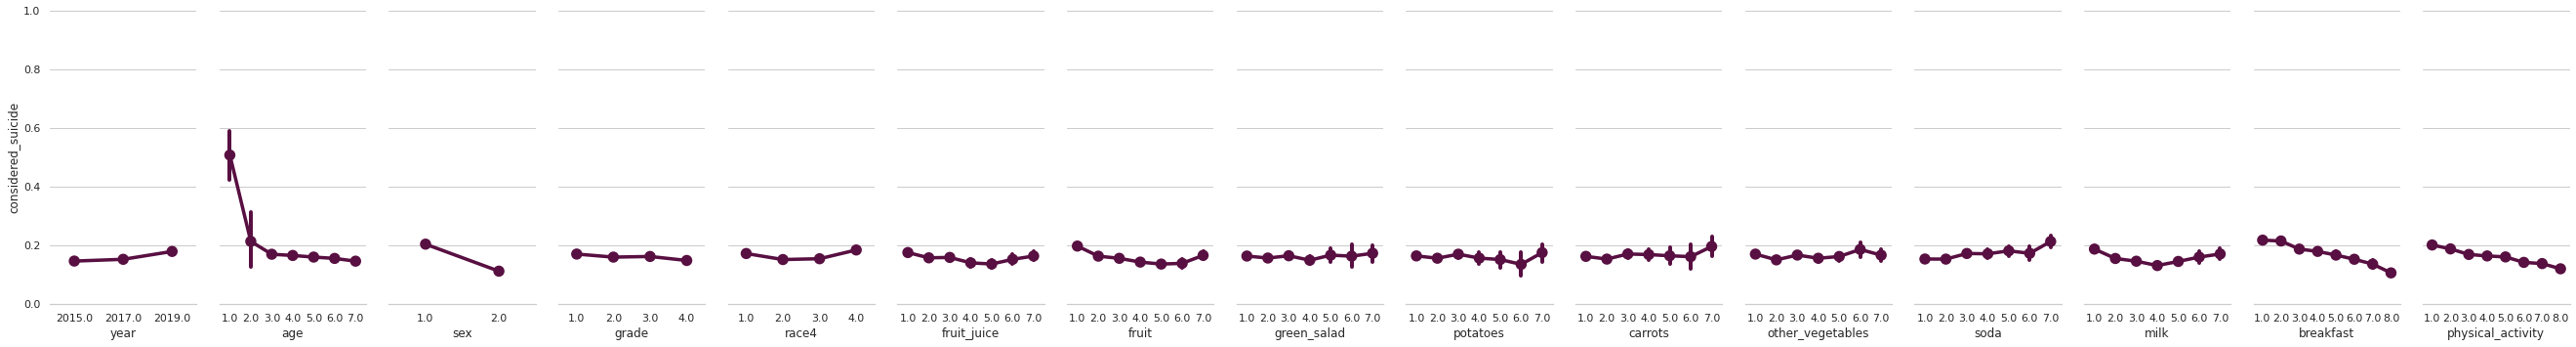

In [ ]:
## set theme
sns.set_theme(style="whitegrid")

## initialize grid 
g = sns.PairGrid(sub_districtData0, y_vars="considered_suicide",
                 x_vars=['year', 'age', 'sex', 'grade', 'race4', 'fruit_juice', 'fruit', 'green_salad', 'potatoes', 'carrots', 'other_vegetables', 'soda', 'milk', 'breakfast', 'physical_activity'],
                 height=5, aspect=.5)

## draw seaborn pointplot onto each set of axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

From the above set of plots, it would seem that many of the covariates (year, age, sex) have relationships with the outcome (considered_suicide). A few of the predictors appear to have very strong relationships with the outcome, includingsoda, breakfast, and physical activity. 

Now, we will fit univariate regression models for each of the covariates/predictors. This may indicate which covariates/predictors have significant relationships to considered_suicide.

Remember that our 'univariate' models will include each category of the original categorical variable. In this sense, they will technically not be, but conceptually will be, univariate. 

Let's start by fitting all univariate models for our covariates. 

In [ ]:
Xtrain = sub_districtData[['year_2017.0', 'year_2019.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445736
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145085
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                0.001027
Time:                        19:41:26   Log-Likelihood:                -64671.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.341e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7313      0.014   -127.007      0.000      -1.758      -1.705
year_2017.0     0.0776    

In [ ]:
Xtrain = sub_districtData[['sex_2.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.439970
         Iterations 6


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145086
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.01395
Time:                        19:41:27   Log-Likelihood:                -63834.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3658      0.009   -151.088      0.000      -1.383      -1.348
sex_2.0       -0.6151      0.015    -41.785      0.000      -0.644      -0.586


In [ ]:
Xtrain = sub_districtData[['grade_2.0', 'grade_3.0', 'grade_4.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.446063
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145084
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0002937
Time:                        19:41:29   Log-Likelihood:                -64718.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 2.783e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5752      0.013   -118.710      0.000      -1.601      -1.549
grade_2.0     -0.0488      0.

In [ ]:
Xtrain = sub_districtData[['race4_2.0', 'race4_3.0', 'race4_4.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.446058
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145084
Method:                           MLE   Df Model:                            3
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0003051
Time:                        19:41:30   Log-Likelihood:                -64718.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.360e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5666      0.016   -100.595      0.000      -1.597      -1.536
race4_2.0     -0.1190      0.

As evident from the above output, all covariates were found to be significant in their univariate models with q26. 

Now, let's examine the univariate relationships between our predictor set and the outcome. 

In [ ]:
Xtrain = sub_districtData[['fruit_juice_2.0', 'fruit_juice_3.0', 'fruit_juice_4.0', 'fruit_juice_5.0', 'fruit_juice_6.0', 'fruit_juice_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.446017
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0003973
Time:                        19:41:31   Log-Likelihood:                -64712.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 2.421e-09
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5751      0.011   -140.083      0.000      -1.597      -1.553
fruit_juice_2.

In [ ]:
Xtrain = sub_districtData[['fruit_2.0', 'fruit_3.0', 'fruit_4.0', 'fruit_5.0', 'fruit_6.0', 'fruit_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445545
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                0.001454
Time:                        19:41:32   Log-Likelihood:                -64643.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 6.111e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5085      0.014   -109.895      0.000      -1.535      -1.482
fruit_2.0     -0.1089      0.

In [ ]:
Xtrain = sub_districtData[['green_salad_2.0', 'green_salad_3.0', 'green_salad_4.0', 'green_salad_5.0', 'green_salad_6.0', 'green_salad_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.446054
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0003144
Time:                        19:41:34   Log-Likelihood:                -64717.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 3.309e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.6537      0.008   -195.705      0.000      -1.670      -1.637
green_salad_2.

In [ ]:
Xtrain = sub_districtData[['potatoes_2.0', 'potatoes_3.0', 'potatoes_4.0', 'potatoes_5.0', 'potatoes_6.0', 'potatoes_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445911
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0006351
Time:                        19:41:35   Log-Likelihood:                -64696.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.238e-15
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.6565      0.009   -193.094      0.000      -1.673      -1.640
potatoes_2.0     0.0371

In [ ]:
Xtrain = sub_districtData[['carrots_2.0', 'carrots_3.0', 'carrots_4.0', 'carrots_5.0', 'carrots_6.0', 'carrots_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445960
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0005232
Time:                        19:41:36   Log-Likelihood:                -64704.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.184e-12
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.6496      0.008   -203.665      0.000      -1.666      -1.634
carrots_2.0     0.0353    

In [ ]:
Xtrain = sub_districtData[['other_vegetables_2.0', 'other_vegetables_3.0', 'other_vegetables_4.0', 'other_vegetables_5.0', 'other_vegetables_6.0', 'other_vegetables_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445981
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:               0.0004774
Time:                        19:41:37   Log-Likelihood:                -64706.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.930e-11
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6631      0.009   -180.268      0.000      -1.681      -1.645

In [ ]:
Xtrain = sub_districtData[['soda_2.0', 'soda_3.0', 'soda_4.0', 'soda_5.0', 'soda_6.0', 'soda_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445634
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                0.001254
Time:                        19:41:38   Log-Likelihood:                -64656.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 1.831e-32
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6254      0.010   -155.096      0.000      -1.646      -1.605
soda_2.0      -0.0972      0.

In [ ]:
Xtrain = sub_districtData[['milk_2.0', 'milk_3.0', 'milk_4.0', 'milk_5.0', 'milk_6.0', 'milk_7.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.445192
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145081
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                0.002246
Time:                        19:41:40   Log-Likelihood:                -64592.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                 7.693e-60
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5377      0.009   -168.956      0.000      -1.556      -1.520
milk_2.0      -0.1946      0.

In [ ]:
Xtrain = sub_districtData[['breakfast_2.0', 'breakfast_3.0', 'breakfast_4.0', 'breakfast_5.0', 'breakfast_6.0', 'breakfast_7.0', 'breakfast_8.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.441608
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145080
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.01028
Time:                        19:41:41   Log-Likelihood:                -64072.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                3.540e-283
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4833      0.011   -139.108      0.000      -1.504      -1.462
breakfast_2.0     0.

In [ ]:
Xtrain = sub_districtData[['physical_activity_2.0', 'physical_activity_3.0', 'physical_activity_4.0', 'physical_activity_5.0', 'physical_activity_6.0', 'physical_activity_7.0', 'physical_activity_8.0']]
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.444387
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145080
Method:                           MLE   Df Model:                            7
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                0.004050
Time:                        19:41:42   Log-Likelihood:                -64475.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                4.488e-109
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.4787      0.012   -122.000      0.000      -1.502      -1.

Next, let's take a look at the unadjusted model (i.e., no covariates included) including all predictors.

In [ ]:
Xtrain = sub_districtData.drop(columns = ['considered_suicide', 'year_2017.0', 'year_2019.0', 'sex_2.0', 'grade_2.0', 'grade_3.0', 'grade_4.0', 'race4_2.0', 'race4_3.0', 'race4_4.0'])
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.437870
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145019
Method:                           MLE   Df Model:                           68
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.01866
Time:                        19:41:45   Log-Likelihood:                -63530.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4927      0.062     -8.008      0.000      -0.613      -0.

Finally, let's look at the covariate adjusted model including all predictors. 

In [ ]:
Xtrain = sub_districtData.drop(columns = 'considered_suicide')
ytrain = sub_districtData[['considered_suicide']]

Xtrain = sm.add_constant(Xtrain)

log_reg = sm.Logit(ytrain, Xtrain).fit()

print(log_reg.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.431375
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:     considered_suicide   No. Observations:               145088
Model:                          Logit   Df Residuals:                   145010
Method:                           MLE   Df Model:                           77
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.03321
Time:                        19:41:48   Log-Likelihood:                -62587.
converged:                       True   LL-Null:                       -64737.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2390      0.066     -3.638      0.000      -0.368      -0.

Now, we can transform these coefficient results for the adjusted model to get our odds ratios.

In [ ]:
log_odds_ratios = log_reg.params #Logit coefficients
odds_ratios = np.exp(log_odds_ratios) #exponentiate to get odds ratio

dict(sorted(odds_ratios.items(), key=lambda item: item[1]))

{'age_3.0': 0.40392492945140995,
 'age_4.0': 0.4056031458265498,
 'age_6.0': 0.41093735601492415,
 'age_7.0': 0.41610332912592907,
 'age_5.0': 0.4240325647334001,
 'age_2.0': 0.4614041001797305,
 'sex_2.0': 0.5346839524026209,
 'breakfast_8.0': 0.5608389643535708,
 'breakfast_7.0': 0.7098746130758268,
 'fruit_5.0': 0.7415128189571385,
 'fruit_6.0': 0.7820117668737716,
 'const': 0.7874304736689556,
 'physical_activity_8.0': 0.7910784531940673,
 'fruit_4.0': 0.7991889484641534,
 'breakfast_6.0': 0.8172375747553035,
 'physical_activity_6.0': 0.8199851041691757,
 'race4_2.0': 0.8203802148592265,
 'physical_activity_7.0': 0.827626755432782,
 'breakfast_5.0': 0.8795180343418114,
 'fruit_7.0': 0.884390100265916,
 'fruit_3.0': 0.8863912859184407,
 'physical_activity_5.0': 0.8936965337696103,
 'grade_4.0': 0.8940733736388567,
 'race4_3.0': 0.8960536874281907,
 'fruit_2.0': 0.898651340927478,
 'milk_4.0': 0.899120690920282,
 'physical_activity_4.0': 0.9046818694285551,
 'physical_activity_3.0': 

## Part 2: Predictive Modeling

Now, we explore different types of classification models, and see which is best at predicting our outcome using the variables of interest. 

First, let's perform a train-test split to prepare our data.

In [ ]:
Y = sub_districtData.considered_suicide
X = sub_districtData.drop(columns = 'considered_suicide')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10)

Now, let's fit our first model: a standard classification tree. 

In [ ]:
## fit model
DT_class = DecisionTreeClassifier(max_depth = None, random_state = 10)
DT_class.fit(X_train, Y_train)

## calculate predictions on test set
DT_class_pred = DT_class.predict(X_test)

## output confusion matrix + accuracy
classificationSummary(Y_test, DT_class_pred)

Confusion Matrix (Accuracy 0.7900)

       Prediction
Actual     0     1
     0 21218  3023
     1  3070  1707


Next, let's fit a model using the bagging ensemble method.

In [ ]:
## fit model
DT_class_bag = RandomForestClassifier(max_features = len(X_train.columns), random_state = 10)
DT_class_bag.fit(X_train, Y_train)

## calculate predictions on test set
DT_class_bag_pred = DT_class_bag.predict(X_test)

## output confusion matrix + accuracy
classificationSummary(Y_test, DT_class_bag_pred)

Confusion Matrix (Accuracy 0.8593)

       Prediction
Actual     0     1
     0 23807   434
     1  3648  1129


Now, let's fit a model using the random forest ensemble method.

In [ ]:
## fit model
DT_class_RF = RandomForestClassifier(max_features = round(np.sqrt(len(X_train.columns))), random_state = 10)
DT_class_RF.fit(X_train, Y_train)

## calculate predictions on test set
DT_class_RF_pred = DT_class_RF.predict(X_test)

## output confusion matrix + accuracy
classificationSummary(Y_test, DT_class_RF_pred)

Confusion Matrix (Accuracy 0.8631)

       Prediction
Actual     0     1
     0 23989   252
     1  3721  1056


Finally, let's fit a model using the boosting ensemble method.

In [ ]:
## fit model
DT_class_boost = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.01, random_state = 10)
DT_class_boost.fit(X_train, Y_train)

## calculate predictions on test set
DT_class_boost_pred = DT_class_boost.predict(X_test)

## output confusion matrix + accuracy
classificationSummary(Y_test, DT_class_boost_pred)

Confusion Matrix (Accuracy 0.8354)

       Prediction
Actual     0     1
     0 24241     0
     1  4777     0


Although test definitely improved with each of the ensemble methods, the sensitivity is quite poor in each case. In other words, the models do a poor job of predicting a positive outcome - this is quite concerning, considering the gravity of the outcome!

One thing we can do to fix this is tune the decision threshold (i.e., the value of predicted probability that separates event from non-event classification). Let's do this for the boosted model.

In [ ]:
for i in np.linspace(0, 0.5, 6):
  ## calculate predictions on test set
  DT_class_boost_pred = (DT_class_bag.predict_proba(X_test)[:,1] >= i).astype(bool)

  ## output confusion matrix + accuracy
  print("threshold: ")
  print(i)
  classificationSummary(Y_test, DT_class_boost_pred)

threshold: 
0.0
Confusion Matrix (Accuracy 0.1646)

       Prediction
Actual     0     1
     0     0 24241
     1     0  4777
threshold: 
0.1
Confusion Matrix (Accuracy 0.4726)

       Prediction
Actual     0     1
     0  9583 14658
     1   645  4132
threshold: 
0.2
Confusion Matrix (Accuracy 0.6692)

       Prediction
Actual     0     1
     0 16360  7881
     1  1719  3058
threshold: 
0.30000000000000004
Confusion Matrix (Accuracy 0.7899)

       Prediction
Actual     0     1
     0 20861  3380
     1  2718  2059
threshold: 
0.4
Confusion Matrix (Accuracy 0.8361)

       Prediction
Actual     0     1
     0 22837  1404
     1  3352  1425
threshold: 
0.5
Confusion Matrix (Accuracy 0.8584)

       Prediction
Actual     0     1
     0 23776   465
     1  3643  1134


## Limitations

- may have been better to collapse categories for the predictors
- could do much more in-depth modeling to improve predictive performance
- only looked at relatively small subset of one of the datasets!